# Предсказание ДТП

### Описание проекта
Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика: 
1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

2. На основе модели исследовать основные факторы ДТП.


3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

## 1. Подключение к базе и загрузка таблицы SQL

Для начала импортируем все необходимые для работы библиотеки.

In [1]:
import pandas as pd
import random
import pylab
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix

Поскольку нам необходимо получить данные из БД, создадим и настроим подключение.

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

Для начала посмотрим, какие таблицы присутствуют в схеме БД.

In [3]:
query = '''
SELECT table_catalog, table_schema, table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE'
'''

schema = pd.read_sql_query(query, con=engine)
schema

,table_catalog,table_schema,table_name
0,data-science-vehicle-db,pg_catalog,pg_type
1,data-science-vehicle-db,pg_catalog,pg_foreign_table
2,data-science-vehicle-db,pg_catalog,pg_amop
3,data-science-vehicle-db,pg_catalog,pg_amproc
4,data-science-vehicle-db,pg_catalog,pg_language
...,...,...,...
59,data-science-vehicle-db,pg_catalog,pg_inherits
60,data-science-vehicle-db,public,collisions
61,data-science-vehicle-db,public,case_ids
62,data-science-vehicle-db,public,parties


Нам предстоит работать с таблицами `collisions`, `parties` `vehicles`, они находятся в схеме `public`. Данная схема используется по умолчанию, поэтому мы можем не указывать ее в своих запросах. 

Рассмотрим имеющиеся таблицы:

- `collisions` — общая информация о ДТП

Имеет уникальный `case_id`. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

In [4]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

collisions_df = pd.read_sql_query(query, con=engine)
collisions_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


- `parties` — информация об участниках ДТП

Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `case_id`. Если нужен уникальный идентификатор, это `case_id` и `party_number`.

In [5]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

parties_df = pd.read_sql_query(query, con=engine)
parties_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


- `vehicles` — информация о пострадавших машинах

Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. Если нужен уникальный идентификатор, это `case_id` и `party_number`.

In [6]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

vehicles_df = pd.read_sql_query(query, con=engine)
vehicles_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


- `case_ids` - Дополнительная таблица, связывающая все описанные выше по полю `case_id`

In [7]:
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

case_ids_df = pd.read_sql_query(query, con=engine)
case_ids_df

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


## 2. Первичное исследование таблиц

Для первичного исследования нам необходимо ответить на несколько вопросов:

- Все ли таблицы имеют набор данных

In [8]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

df_check = pd.read_sql_query(query, con=engine)
df_check

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [9]:
query = '''
SELECT
    COUNT(*) AS COUNT_ALL,
    COUNT(case_id),
    COUNT(county_city_location),
    COUNT(county_location),
    COUNT(distance),
    COUNT(direction),
    COUNT(intersection),
    COUNT(weather_1),
    COUNT(location_type),
    COUNT(collision_damage),
    COUNT(party_count),
    COUNT(primary_collision_factor),
    COUNT(pcf_violation_category),
    COUNT(type_of_collision),
    COUNT(motor_vehicle_involved_with),
    COUNT(road_surface),
    COUNT(road_condition_1),
    COUNT(lighting),
    COUNT(control_device),
    COUNT(collision_date),
    COUNT(collision_time)
FROM collisions;
'''

df_check = pd.read_sql_query(query, con=engine)
df_check

,count_all,count,count,count,count,count,count,count,count,count,...,count,count,count,count,count,count,count,count,count,count
0,1400000,1400000,1400000,1400000,1400000,1059358,1387781,1392741,518779,1400000,...,1391834,1372046,1388176,1393181,1386907,1388012,1391407,1391593,1400000,1387692


**Вывод:** Таблица `collisions` заполнена данными согласно схеме БД, некоторые поля имеют пропуски, далее оценим, насколько это критично для обчения. 

In [10]:
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

df_check = pd.read_sql_query(query, con=engine)
df_check

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [11]:
query = '''
SELECT
    COUNT(*) AS COUNT_ALL,
    COUNT(id),
    COUNT(case_id),
    COUNT(party_number),
    COUNT(party_type),
    COUNT(at_fault),
    COUNT(insurance_premium),
    COUNT(party_sobriety),
    COUNT(party_drug_physical),
    COUNT(cellphone_in_use)
FROM parties;
'''

df_check = pd.read_sql_query(query, con=engine)
df_check

,count_all,count,count,count,count,count,count,count,count,count
0,2752408,2752408,2752408,2752408,2748786,2752408,2347006,2678453,432288,2240771


**Вывод:** Таблица `parties` заполнена данными согласно схеме БД, некоторые поля имеют пропуски, далее оценим, насколько это критично для обчения. 

In [12]:
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

df_check = pd.read_sql_query(query, con=engine)
df_check

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [13]:
query = '''
SELECT
    COUNT(*) AS COUNT_ALL,
    COUNT(id),
    COUNT(case_id),
    COUNT(party_number),
    COUNT(vehicle_type),
    COUNT(vehicle_transmission),
    COUNT(vehicle_age)
FROM vehicles;
'''

df_check = pd.read_sql_query(query, con=engine)
df_check

,count_all,count,count,count,count,count,count
0,1021234,1021234,1021234,1021234,1021234,997575,996652


**Вывод:** Таблица `vehicles` заполнена данными согласно схеме БД, некоторые поля имеют пропуски, далее оценим, насколько это критично для обчения.

- Соответствует ли количество таблиц условию задачи

Да. Таблицы в количественном и качественном (содержание) выражении соответствуют условию задачи.

- Имеется ли общий ключ для связи таблиц

Да. Все таблицы имеют поле `case_id`, также таблицы `parties` и `vehicles` дополнительно связываются по полю `party_number` (номер участника).

##  3. Статистический анализ факторов ДТП

#### Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений (таблица `collisions`).

Для начала обратимс к базе SQL и получим данные помесячно за каждый год.

In [14]:
query = '''
SELECT CAST(EXTRACT('YEAR' FROM collision_date) AS INT) AS year, CAST(EXTRACT('MONTH' FROM collision_date) AS INT) AS month, COUNT(*)
FROM collisions
GROUP BY year, month
;
'''

df_stat = pd.read_sql_query(query, con=engine)
df_stat

,year,month,count
0,2009,1,35062
1,2009,2,34480
2,2009,3,36648
3,2009,4,35239
4,2009,5,36916
5,2009,6,34202
6,2009,7,35161
7,2009,8,34508
8,2009,9,35555
9,2009,10,37835


Данные за `2013` и `2020` года практически отсутствуют, для целей анализа не будем их учитывать.

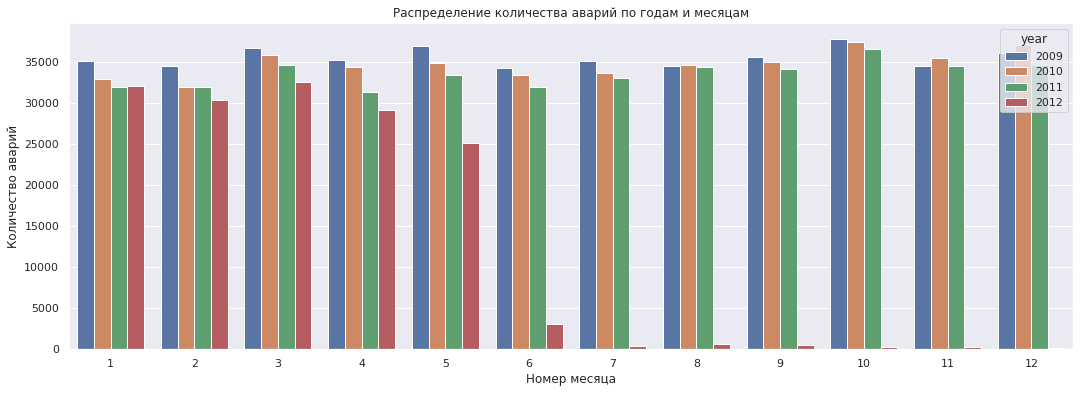

In [15]:
df_stat = df_stat[df_stat['year'] < 2013]

sns.set(rc={'figure.figsize':(18,6)})
ax = sns.barplot(x='month',
            y='count',
            hue='year',
            data=df_stat)

ax.set_title('Распределение количества аварий по годам и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Количество аварий');

Согласно графику мы видим, что разница по количеству аварий в зависимости от года или месяца не является колоссальной, все месяцы показывают примерно одинаковые результаты от года к году. Однако уже сейчас можно заметить, что в последние месяцы года ситуация с количеством аварий несколько ухудшается.

Поскольку количество информции по авариям начинает аномально снижаться в 2012 году, построим график по среднему количеству аварий до этого года.

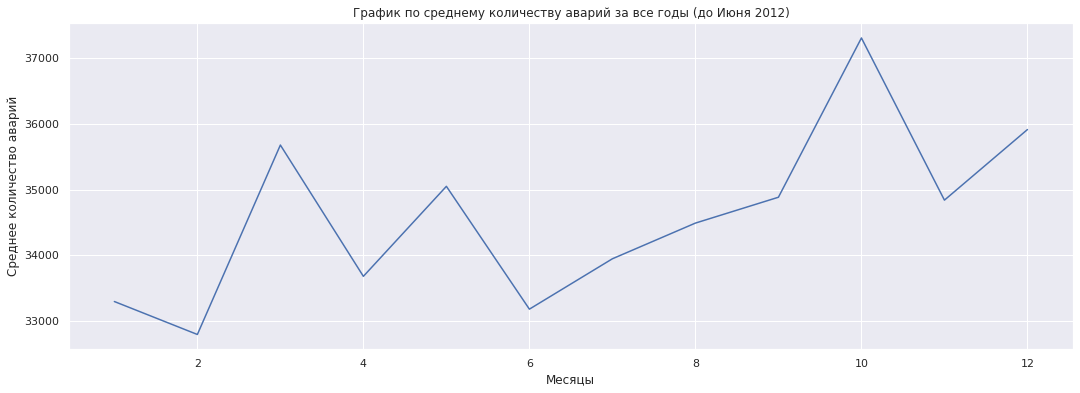

In [16]:
df_stat[df_stat['year'] < 2012].groupby('month')['count'].mean().plot()
plt.title('График по среднему количеству аварий за все годы (до Июня 2012)')
plt.xlabel('Месяцы')
plt.ylabel('Среднее количество аварий')
plt.show()

Для удобства график отображает среднее количество аварий по годам, начиная с 32 000.

Таким образом мы видим, что наибольшее количество аварий происходит в период `Октябрь-Декабрь`. Вероятно, это связано с тем, что автовладельцы не успевают своевременно сменить колеса своих машин на зимние (с шиповкой), что повышает вероятность попадания в аварию.

Также мы наблюдаем некоторый скачек в росте количества аварий в `Марте`. Это опять же может быть связано с несвоевременной сменой зимней резины на летнюю. Однако последствий не приводят к таким плачевным результатам, как при перехде на зимнюю резину, поскольку здесь уже влияет не фактор ухудшения контроля авто при скольжении из-за смены погодных условий, а неудобство контроля самого авто на неподходящей резине.

#### Постановка предварительных аналитических задач

1. Определите влияние особенностей автомобиля на серьезность аварии (связать `vehicles` и `collisions`).
2. Проведите анализ влияния факторов, связанных с водителем, на серьезность аварии (связать `parties` и `collisions`).
3. Проанализируйте влияние природных факторов на серьезность аварий: погодные условия, сезон, время суток и т.д. (таблица `collisions`).
4. Определите самые частые места аварий: перекресток или нет, состояние дороги, географические районы, расстояние от главной дороги, тип дороги, дорожное состояние (таблица `collisions`).
5. Определите основные места аварий по серьезности происшествия: перекресток или нет, состояние дороги, географические районы, расстояние от главной дороги, тип дороги, дорожное состояние (таблица `collisions`).
6. Проведите анализ серьёзности повреждений транспортного средства исходя из причин ДТП и количества участников (таблица `collisions`).

#### Проведем работу для двух задач из списка
Задача 1:
- Создайте SQL-запрос (связать `vehicles` и `collisions` по полю `case_id`);
- Сгруппируйте записи и определите количество аварий по полям: Тип кузова, Тип КПП, Возраст автомобиля (в годах).
- Постройте графики для наглядности определения присутствия влияния на серьезность аварий.
- Сделайте вывод.



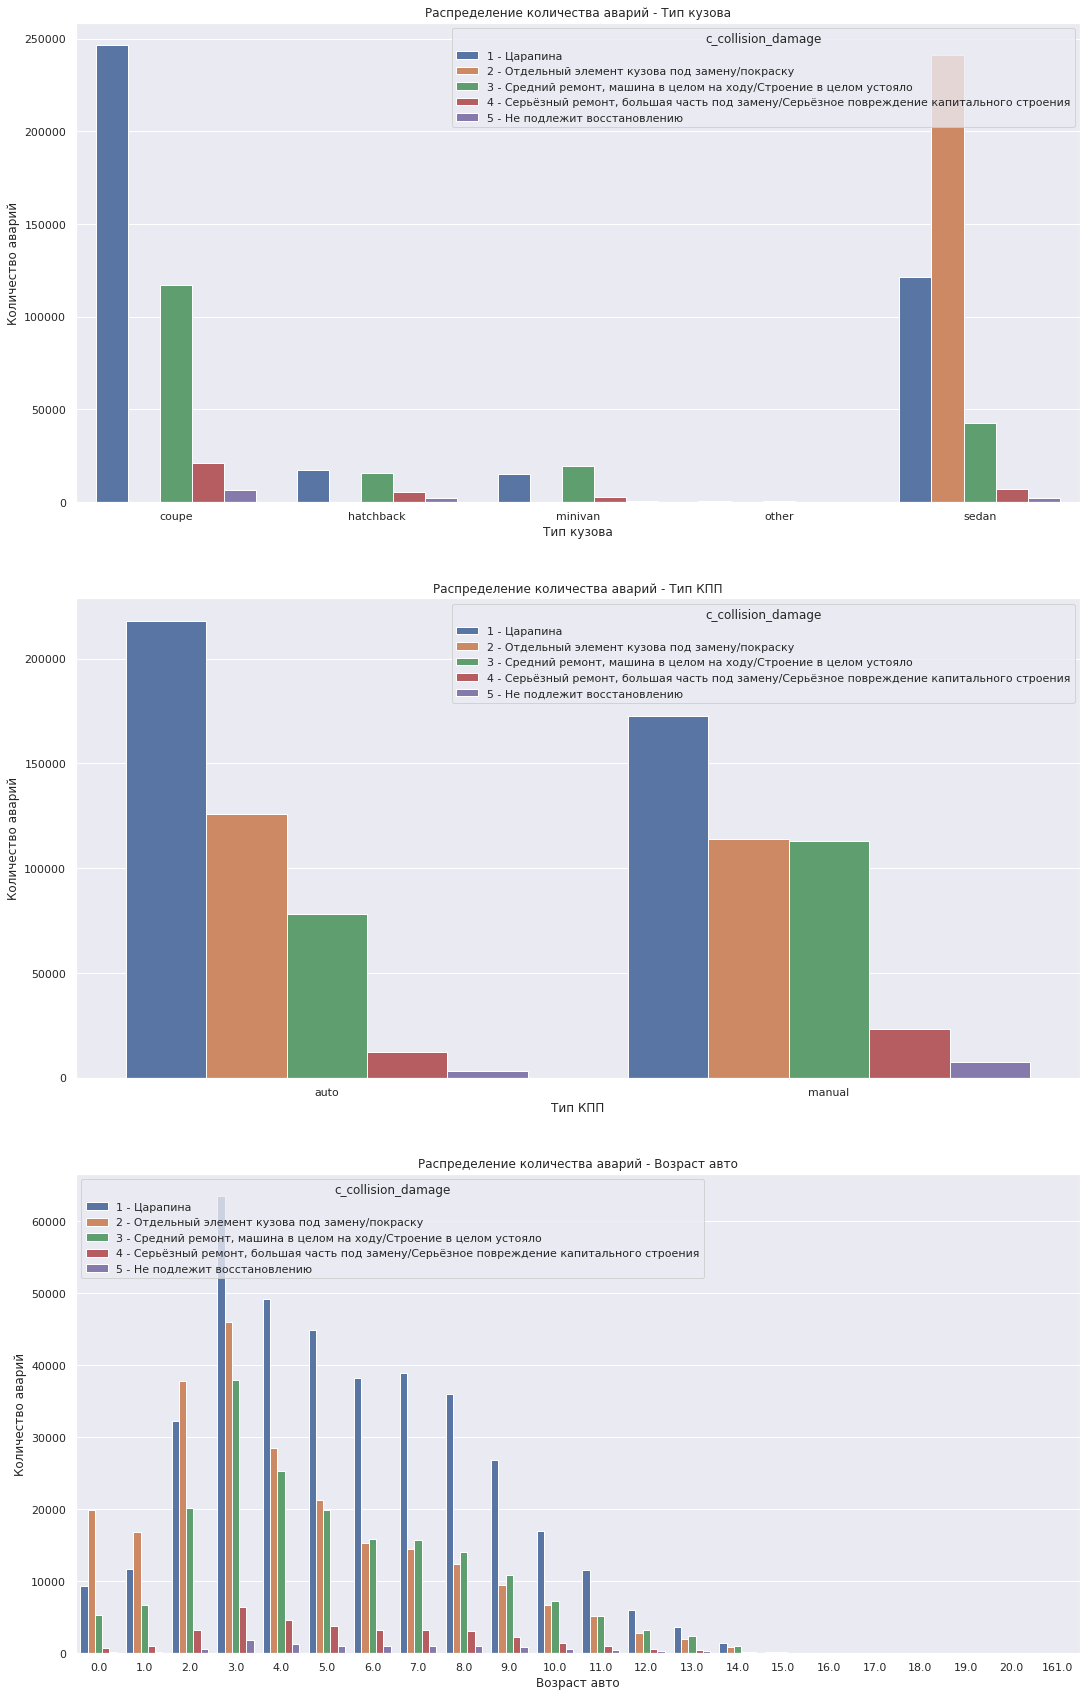

In [17]:
query = '''
SELECT
    c.collision_damage as c_collision_damage,
    v.vehicle_type as v_vehicle_type,
    v.vehicle_transmission as v_vehicle_transmission,
    v.vehicle_age as v_vehicle_age
FROM collisions c
    LEFT JOIN vehicles v ON v.case_id = c.case_id
WHERE 1=1
    AND c.collision_date < '2012-01-01'
'''

task_1 = pd.read_sql_query(query, con=engine)

def collision_damage(val):
    if val == 'scratch':
        return '1 - Царапина'
    elif val == 'small damage':
        return '2 - Отдельный элемент кузова под замену/покраску'
    elif val == 'middle damage':
        return '3 - Средний ремонт, машина в целом на ходу/Строение в целом устояло'
    elif val == 'severe damage':
        return '4 - Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения'
    elif val == 'fatal':
        return '5 - Не подлежит восстановлению'

task_1['c_collision_damage'] = task_1['c_collision_damage'].apply(collision_damage)

sns.set(rc={'figure.figsize':(18,30)})

pylab.subplot(3, 1, 1)
pivot_table = pd.pivot_table(task_1, index=['c_collision_damage','v_vehicle_type'], values='v_vehicle_age', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'v_vehicle_age': 'count'})
ax = sns.barplot(x='v_vehicle_type',
            y='count',
            hue='c_collision_damage',
            data=df_stat)
ax.set_title('Распределение количества аварий - Тип кузова')
ax.set(xlabel='Тип кузова', ylabel='Количество аварий');

pylab.subplot(3, 1, 2)
pivot_table = pd.pivot_table(task_1, index=['c_collision_damage','v_vehicle_transmission'], values='v_vehicle_age', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'v_vehicle_age': 'count'})
ax = sns.barplot(x='v_vehicle_transmission',
            y='count',
            hue='c_collision_damage',
            data=df_stat)
ax.set_title('Распределение количества аварий - Тип КПП')
ax.set(xlabel='Тип КПП', ylabel='Количество аварий');

pylab.subplot(3, 1, 3)
pivot_table = pd.pivot_table(task_1, index=['c_collision_damage','v_vehicle_age'], values='v_vehicle_transmission', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'v_vehicle_transmission': 'count'})
ax = sns.barplot(x='v_vehicle_age',
            y='count',
            hue='c_collision_damage',
            data=df_stat)
ax.set_title('Распределение количества аварий - Возраст авто')
ax.set(xlabel='Возраст авто', ylabel='Количество аварий');

Согласно графикам мы можем сделать следующие выводы:
1. Тип кузова `coupe` имеет самый частый исход аварий с царапинами, серьезным ремонтом и не подлежащему ремонту авто. При этом совершенно отсутствуют аварии, в результате которых авто требуется деталь под замену. Возможно, это связано с тем, что авто с таким типом кузова берут в аренду водители, любящие превышать скорость, однако сам тип кузова является достаточно хорошо сконструированным для того, чтобы отделаться царапиной, либо, такой тип кузова не имеет возможности замены отдельного элемента. Тип кузова `sedan` имеет обратную картину - вероятно, это связано с тем, что у такого типа кузова проще помять элементы, любой чуть более сильный удар приведет не к царапине, а к необходимости замены части кузова.
2. Тип КПП делится на `auto` и `manual`. В целом, особого влияния мы не видим - чаще всего происходят легкие аварии с царапинами, реже более серьезные. Таким образом мы наблюдаем планомерное убыванию по количеству аварий на фоне серьезности ДТП. Однако, можно отметить, что у ручного типа КПП выбивается из общей картины количество аварий со средним ремонтом по итогу, а также больше более серьезных аварий в целом. Это может быть связано со сложностью управления ручной КПП, особенно в аварийной ситуации.
3. По годам аварии имеют очертания нормального распределения. При этом начиная с возраста авто 3 года достигается пик аварий, однако количество аварий также распределены по серьезности аварии. Начиная с этого возраста общее количество начинает уменьшаться, а вот с 6 лет количество аварий с серьезным ремонтом начинает несущественно превышать средний. До 3 лет авто чаще всего попадает в ДТП с отдельным элементом кузова под замену. А вот машин возрастом более 13-14 лет на дорогах практически не осталось, либо их владельцы водят максимально осторожно, возможно, также в силу своего собственного возраста. Также мы видим авто возрастом 161 год, скорее всего, это уникальный случай далее в рамках предобработки данных мы исследуем такие записи и избавимся от аномального случая.

Задача 2:
- Создайте SQL-запрос (связать `parties` и `collisions` по полю `case_id`, установите отбор на Тип участника происшествия - `1 — Car (Авто)`);
- Сгруппируйте записи и определите количество аварий по полям: Виновность участника, Состояние участника, Трезвость участника. 
- Постройте графики для наглядности определения присутствия влияния на количество аварий, в том числе на виновность.
- Сделайте вывод.

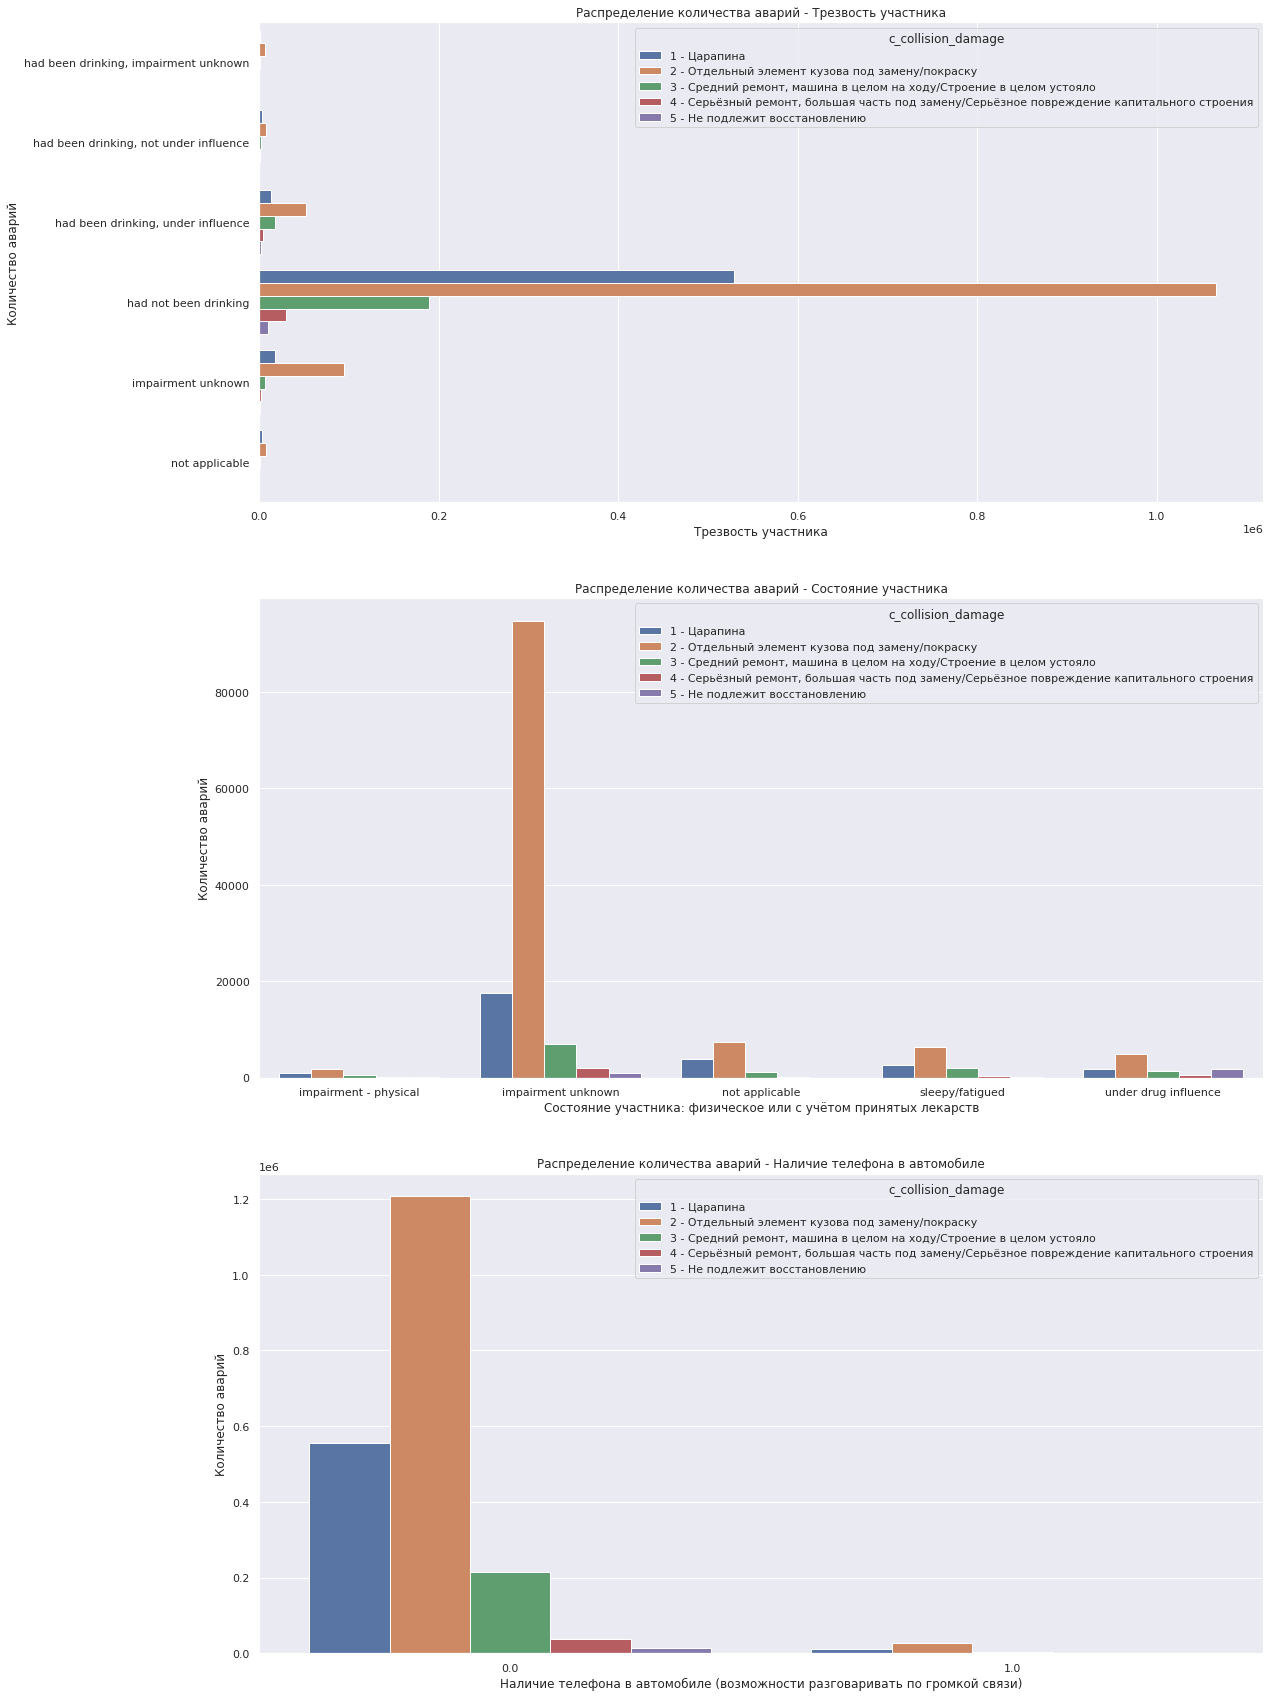

In [18]:
query = '''
SELECT
    c.collision_damage as c_collision_damage,
    p.party_sobriety as p_party_sobriety,
    p.party_drug_physical as p_party_drug_physical,
    p.cellphone_in_use as p_cellphone_in_use
FROM collisions c
    LEFT JOIN parties p ON p.case_id = c.case_id
WHERE 1=1
    AND p.party_type = 'car'
'''

task_2 = pd.read_sql_query(query, con=engine)
task_2['c_collision_damage'] = task_2['c_collision_damage'].apply(collision_damage)
task_2.loc[task_2['p_party_drug_physical']=='G', 'p_party_drug_physical'] = 'impairment unknown'

pylab.subplot(3, 1, 1)
pivot_table = pd.pivot_table(task_2, index=['c_collision_damage','p_party_sobriety'], values='p_cellphone_in_use', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'p_cellphone_in_use': 'count'})
ax = sns.barplot(x='count',
            y='p_party_sobriety',
            hue='c_collision_damage',
            data=df_stat)
ax.set_title('Распределение количества аварий - Трезвость участника')
ax.set(xlabel='Трезвость участника', ylabel='Количество аварий');

pylab.subplot(3, 1, 2)
pivot_table = pd.pivot_table(task_2, index=['c_collision_damage','p_party_drug_physical'], values='p_cellphone_in_use', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'p_cellphone_in_use': 'count'})
ax = sns.barplot(x='p_party_drug_physical',
            y='count',
            hue='c_collision_damage',
            data=df_stat)
ax.set_title('Распределение количества аварий - Состояние участника')
ax.set(xlabel='Состояние участника: физическое или с учётом принятых лекарств', ylabel='Количество аварий');

pylab.subplot(3, 1, 3)
pivot_table = pd.pivot_table(task_2, index=['c_collision_damage','p_cellphone_in_use'], values='p_party_sobriety', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'p_party_sobriety': 'count'})
ax = sns.barplot(x='p_cellphone_in_use',
            y='count',
            hue='c_collision_damage',
            data=df_stat)
ax.set_title('Распределение количества аварий - Наличие телефона в автомобиле')
ax.set(xlabel='Наличие телефона в автомобиле (возможности разговаривать по громкой связи)', ylabel='Количество аварий');

Согласно графикам мы можем сделать следующие выводы:
1. Чаще всего учатник аварии не был в состоянии алкогольного опьянения. Однако также мы можем наблюдать, что также есть небольшое количество аварий с водителями с алкогольным опьянением и с неизвестной информацией по водителю. Возможно, последнее связано с тем, что водители, находящиеся в состоянии алкогольного опьянения, чаще покидают место аварии, поскольку чаще являются виновниками, либо для того, чтобы не понести за свое состояние наказание.
2. В большинстве случае неизвестно состояние водителя по результатам аварии. Вероятно, это связано с тем, что водителя чаще тестируют на содержание алкоголя в организме, а вот устройство для определения его состояния пока не придумали. таким образом, водитель может легко скрыть факты о своем состоянии.
3. В большинстве случаев в авто отсутствовал телефон.

## 4. Модель для оценки водительского риска

#### Подготовим набор данных на основе первичного предположения заказчика:
- Выберите тип виновника — только `машина (car)`.
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа `SCRATCH (царапина)`.
- Для моделирования возьмите данные только за `2012 год`.
- Подготовка исходной таблицы должна проводиться с помощью SQL-запроса.

Составим запрос к БД и получим данные согласно условиям задания.

In [19]:
query = '''
SELECT
    c.case_id as c_case_id,
    c.county_city_location as c_county_city_location,
    c.county_location as c_county_location,
    c.distance as c_distance,
    c.direction as c_direction,
    c.intersection as c_intersection,
    c.weather_1 as c_weather_1,
    c.location_type as c_location_type,
    c.collision_damage as c_collision_damage,
    c.party_count as c_party_count,
    c.primary_collision_factor as c_primary_collision_factor,
    c.pcf_violation_category as c_pcf_violation_category,
    c.type_of_collision as c_type_of_collision,
    c.motor_vehicle_involved_with as c_motor_vehicle_involved_with,
    c.road_surface as c_road_surface,
    c.road_condition_1 as c_road_condition_1,
    c.lighting as c_lighting,
    c.control_device as c_control_device,
    c.collision_date as c_collision_date,
    c.collision_time as c_collision_time,
    p.id as p_id,
    p.party_number as p_party_number,
    p.party_type as p_party_type,
    p.at_fault as p_at_fault,
    p.insurance_premium as p_insurance_premium,
    p.party_sobriety as p_party_sobriety,
    p.party_drug_physical as p_party_drug_physical,
    p.cellphone_in_use as p_cellphone_in_use,
    v.id as v_id,
    v.vehicle_type as v_vehicle_type,
    v.vehicle_transmission as v_vehicle_transmission,
    v.vehicle_age as v_vehicle_age
FROM collisions c
    LEFT JOIN parties p ON p.case_id = c.case_id
    LEFT JOIN vehicles v ON v.case_id = c.case_id AND v.party_number = p.party_number
WHERE 1=1
    AND p.party_type = 'car'
    AND c.collision_damage <> 'scratch'
    AND CAST(EXTRACT('YEAR' FROM collision_date) AS INT) = 2012
'''

sql_df = pd.read_sql_query(query, con=engine)
sql_df

,c_case_id,c_county_city_location,c_county_location,c_distance,c_direction,c_intersection,c_weather_1,c_location_type,c_collision_damage,c_party_count,...,p_party_type,p_at_fault,p_insurance_premium,p_party_sobriety,p_party_drug_physical,p_cellphone_in_use,v_id,v_vehicle_type,v_vehicle_transmission,v_vehicle_age
0,5464784,3315,riverside,1500.0,east,0.0,cloudy,highway,small damage,5,...,car,0,52.0,had not been drinking,None,0.0,NaN,None,None,NaN
1,5490978,3313,riverside,200.0,east,0.0,clear,highway,small damage,4,...,car,1,22.0,had not been drinking,None,0.0,NaN,None,None,NaN
2,5456844,3015,orange,65.0,north,0.0,clear,None,middle damage,4,...,car,0,76.0,had not been drinking,None,0.0,1328512.0,sedan,auto,12.0
3,5520415,0104,alameda,300.0,west,0.0,clear,highway,small damage,4,...,car,0,23.0,had not been drinking,None,0.0,NaN,None,None,NaN
4,5531911,2700,monterey,1584.0,south,0.0,clear,highway,middle damage,4,...,car,0,22.0,had not been drinking,None,0.0,NaN,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196832,5517885,3015,orange,410.0,north,0.0,cloudy,None,small damage,1,...,car,1,19.0,had not been drinking,None,0.0,NaN,None,None,NaN
196833,5517903,0105,alameda,200.0,south,0.0,clear,highway,small damage,3,...,car,1,25.0,had not been drinking,None,0.0,NaN,None,None,NaN
196834,5517903,0105,alameda,200.0,south,0.0,clear,highway,small damage,3,...,car,0,45.0,had not been drinking,None,0.0,1389370.0,sedan,auto,5.0
196835,5517921,3900,san joaquin,0.0,None,1.0,clear,None,middle damage,2,...,car,1,32.0,had not been drinking,None,0.0,1389372.0,sedan,manual,6.0


В рамках данного проекта необходимо разработать модель, предсказывающую уровень риска стать виновником аварии в ДТП для водителя, берущего в прокат автомобиль. Модель должна предсказывать виновность водителя в аварии. Таким образом нам нужно подобрать наилучшую модель для задачи классификации дял таргета `p_at_fault`.

Ниже приведен список всех признаков из общей таблицы, по которым мы укажем целесообразность использования в обучении модели. Каждый признак имеет приставку, которая отражает его принадлежность к первоначальной таблице:

`c` - collisions
`p` - parties
`v` - vehicles

Для удобства сразу классифицируем признаки по обоснованиям, берем мы их к обучению или нет и почему:
- **(1)** Идентификационный номер в базе данных, неинформативный для обучения признак.
- **(2)** Географический признак, влияющий на вероятность ДТП в зависимости от задаваемого маршрута, но не влияющий на вероятность водителя стать виновником, т.к. у невиновного также будет аналогичный признак.
- **(3)** Влияет на риск ДТП, но но не влияет на вероятность водителя стать виновником, т.к. у невиновного также будет аналогичный признак.
- **(4)** Является результатом, а не предпосылкой, невозможно определить заранее.
- **(5)** В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП.
- **(6)** Состояние водителя в отдельных случаях может иметь влияние на риск стать виновником ДТП.

In [20]:
columms = [
#'c_case_id', - Идентификационный номер в базе данных - (1)   
#'c_county_city_location', # Номер географических районов, где произошло ДТП - (2)    
#'c_county_location', # Названия географических районов, где произошло ДТП - (2)    
#'c_distance', # Расстояние от главной дороги (метры)- (2)    
# 'c_direction', # Направление движения - (2)    
'c_intersection', # Является ли место происшествие перекрёстком - (5)   
'c_weather_1', # Погода - (5)
'c_location_type', # Тип дороги - (5)  
#'c_collision_damage', - Серьёзность происшествия - (4)
# 'c_party_count', - Количество участников ДТП - (4)
# 'c_primary_collision_factor', - Основной фактор аварии (4)
# 'c_pcf_violation_category', - Категория нарушения (4)
# 'c_type_of_collision', - Тип аварии (4)
# 'c_motor_vehicle_involved_with', - Дополнительные участники ДТП (4)
'c_road_surface', # Состояние дороги - (5)
'c_road_condition_1', # Дорожное состояние - (5)
'c_lighting', # Освещение - (5)
'c_control_device', # Устройство управления - (5)
# 'c_collision_date', # Дата происшествия - (3)
# 'c_collision_time', # Время происшествия - (3)
# 'p_id', - Индекс таблицы - (1)
# 'p_party_number', - Номер участника происшествия - (1)
# 'p_party_type', - Тип участника происшествия - (4)
# 'p_insurance_premium', - Сумма страховки (тыс. $) - (4)
'p_party_sobriety', # Трезвость участника - (6)
'p_party_drug_physical', # Состояние участника: физическое или с учётом принятых лекарств - (6)
'p_cellphone_in_use', # Наличие телефона в автомобиле (возможности разговаривать по громкой связи) - (5)
# 'v_id', - Индекс таблицы - (1)
'v_vehicle_type', # Тип кузова - (5)
'v_vehicle_transmission', # Тип КПП - (5)
'v_vehicle_age', # Возраст автомобиля (в годах) - (5)
'p_at_fault' # Виновность участника - таргет для обучения
]

Поле `CONTROL_CONDITION_1` (Устройство управления) из описания схемы данных в таблице `collisions` по факту называется `c_control_device`. Рекомедация команде помимо задач выше: обновить описание структуры БД, провести анализ влияния на пользователей/системы, использующих данное поле с целью обновить наименование.

По условиям задачи не указано, проходит ли какое-либо тестирование водитель прежде, чем арендовать авто, поэтому признаки `p_party_sobriety` и `p_party_drug_physical` являются неинформативными. Однако, мы можем дать бизнесу следующие рекомендации:
- Установить детектор алкоголя в салон авто с автоматическим блоком двигателя до прохождения тестирования водителем.
- Прохождение опроса о состоянии водителя (прием лекарств, усталось и т.д.) с автоматическим блоком двигателя до прохождения тестирования водителем.

При условии внедрения такого функционала мы можем использовать данные признаки и улучшить нашу модель. В рамках данного проекта предположим, что указанный функционал был доработал бизнесом.

- **Предобработка**

Для начала сформируем датасет для обучения с выбранными колонками и посмотрим информацию по нему.

In [21]:
df = sql_df[columms]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   c_intersection          195850 non-null  float64
 1   c_weather_1             196183 non-null  object 
 2   c_location_type         87357 non-null   object 
 3   c_road_surface          195564 non-null  object 
 4   c_road_condition_1      195694 non-null  object 
 5   c_lighting              196116 non-null  object 
 6   c_control_device        195864 non-null  object 
 7   p_party_sobriety        193212 non-null  object 
 8   p_party_drug_physical   25148 non-null   object 
 9   p_cellphone_in_use      171464 non-null  float64
 10  v_vehicle_type          56248 non-null   object 
 11  v_vehicle_transmission  55389 non-null   object 
 12  v_vehicle_age           54554 non-null   float64
 13  p_at_fault              196837 non-null  int64  
dtypes: float64(3), int64

Посмотрим признаки на предмет уникальных значений.

In [22]:
df['c_road_surface'].unique()

array(['dry', 'wet', 'snowy', None, 'slippery'], dtype=object)

In [23]:
df['c_road_condition_1'].unique()

array(['normal', 'construction', 'holes', None, 'loose material', 'other',
       'reduced width', 'obstruction', 'flooded'], dtype=object)

In [24]:
df['c_control_device'].unique()

array(['none', 'functioning', 'not functioning', None, 'obscured'],
      dtype=object)

In [25]:
df['p_party_sobriety'].unique()

array(['had not been drinking', None, 'impairment unknown',
       'not applicable', 'had been drinking, not under influence',
       'had been drinking, under influence',
       'had been drinking, impairment unknown'], dtype=object)

In [26]:
df['p_party_drug_physical'].unique()

array([None, 'G', 'not applicable', 'under drug influence',
       'impairment - physical', 'sleepy/fatigued'], dtype=object)

Признак `p_party_drug_physical` содержит значение `G`, это не очень информативно для целей анализа, переименуем его в `impairment unknown`.

In [27]:
df.loc[df['p_party_drug_physical']=='G', 'p_party_drug_physical'] = 'impairment unknown'
df['p_party_drug_physical'].unique()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


array([None, 'impairment unknown', 'not applicable',
       'under drug influence', 'impairment - physical', 'sleepy/fatigued'],
      dtype=object)

In [28]:
df[df['p_party_drug_physical']=='impairment unknown']

,c_intersection,c_weather_1,c_location_type,c_road_surface,c_road_condition_1,c_lighting,c_control_device,p_party_sobriety,p_party_drug_physical,p_cellphone_in_use,v_vehicle_type,v_vehicle_transmission,v_vehicle_age,p_at_fault
38,0.0,cloudy,None,dry,normal,daylight,none,impairment unknown,impairment unknown,0.0,None,None,NaN,0
42,0.0,raining,None,wet,normal,dark with street lights,none,impairment unknown,impairment unknown,NaN,None,None,NaN,1
43,1.0,cloudy,None,dry,normal,daylight,none,impairment unknown,impairment unknown,NaN,None,None,NaN,1
45,0.0,clear,None,dry,normal,dark with street lights,none,impairment unknown,impairment unknown,NaN,None,None,NaN,1
46,0.0,cloudy,None,dry,normal,dusk or dawn,none,impairment unknown,impairment unknown,NaN,None,None,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196808,0.0,clear,highway,dry,normal,daylight,none,impairment unknown,impairment unknown,NaN,sedan,auto,NaN,1
196809,0.0,clear,None,dry,normal,daylight,functioning,impairment unknown,impairment unknown,0.0,None,None,NaN,1
196819,0.0,clear,highway,dry,normal,dark with no street lights,none,impairment unknown,impairment unknown,0.0,None,None,NaN,1
196826,0.0,cloudy,highway,dry,normal,dark with no street lights,none,impairment unknown,impairment unknown,0.0,None,None,NaN,1


In [29]:
df['p_cellphone_in_use'].unique()

array([ 0., nan,  1.])

In [30]:
df['v_vehicle_type'].unique()

array([None, 'sedan', 'coupe', 'other'], dtype=object)

In [31]:
df['v_vehicle_transmission'].unique()

array([None, 'auto', 'manual'], dtype=object)

In [32]:
df['v_vehicle_age'].unique()

array([ nan,  12.,   7.,   3.,   9.,  14.,   4.,   2.,   6.,   5.,  11.,
         8.,   1.,  10.,   0.,  13.,  17.,  16.,  15., 161.,  19.])

Признак `v_vehicle_age` содержит случаи при участии авто возрастом `161 год`. Посмотрим, сколько таких записей и удалим их, если количество небольшое.

In [33]:
df[df['v_vehicle_age']==161]

,c_intersection,c_weather_1,c_location_type,c_road_surface,c_road_condition_1,c_lighting,c_control_device,p_party_sobriety,p_party_drug_physical,p_cellphone_in_use,v_vehicle_type,v_vehicle_transmission,v_vehicle_age,p_at_fault
105111,1.0,clear,ramp,dry,normal,dusk or dawn,functioning,had not been drinking,None,0.0,sedan,manual,161.0,0
184422,0.0,clear,None,dry,normal,daylight,none,had not been drinking,None,0.0,sedan,manual,161.0,1


In [34]:
df = df[df['v_vehicle_age'] != 161]

In [35]:
df['c_intersection'].unique()

array([ 0.,  1., nan])

In [36]:
df['c_weather_1'].unique()

array(['cloudy', 'clear', 'raining', 'snowing', None, 'other', 'fog',
       'wind'], dtype=object)

In [37]:
df['c_location_type'].unique()

array(['highway', None, 'ramp', 'intersection'], dtype=object)

In [38]:
df['c_lighting'].unique()

array(['dark with no street lights', 'daylight',
       'dark with street lights', 'dusk or dawn', None,
       'dark with street lights not functioning'], dtype=object)

В некоторых колонках у нас отсутствуют даные, заполним их значением `не известно`.

In [39]:
df = df.fillna('не известно')
df

,c_intersection,c_weather_1,c_location_type,c_road_surface,c_road_condition_1,c_lighting,c_control_device,p_party_sobriety,p_party_drug_physical,p_cellphone_in_use,v_vehicle_type,v_vehicle_transmission,v_vehicle_age,p_at_fault
0,0.0,cloudy,highway,dry,normal,dark with no street lights,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,0
1,0.0,clear,highway,dry,normal,daylight,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,1
2,0.0,clear,не известно,dry,normal,daylight,none,had not been drinking,не известно,0.0,sedan,auto,12.0,0
3,0.0,clear,highway,dry,normal,dark with no street lights,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,0
4,0.0,clear,highway,dry,normal,daylight,functioning,had not been drinking,не известно,0.0,не известно,не известно,не известно,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196832,0.0,cloudy,не известно,wet,normal,daylight,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,1
196833,0.0,clear,highway,dry,normal,dusk or dawn,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,1
196834,0.0,clear,highway,dry,normal,dusk or dawn,none,had not been drinking,не известно,0.0,sedan,auto,5.0,0
196835,1.0,clear,не известно,dry,normal,daylight,functioning,had not been drinking,не известно,0.0,sedan,manual,6.0,1


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196835 entries, 0 to 196836
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   c_intersection          196835 non-null  object
 1   c_weather_1             196835 non-null  object
 2   c_location_type         196835 non-null  object
 3   c_road_surface          196835 non-null  object
 4   c_road_condition_1      196835 non-null  object
 5   c_lighting              196835 non-null  object
 6   c_control_device        196835 non-null  object
 7   p_party_sobriety        196835 non-null  object
 8   p_party_drug_physical   196835 non-null  object
 9   p_cellphone_in_use      196835 non-null  object
 10  v_vehicle_type          196835 non-null  object
 11  v_vehicle_transmission  196835 non-null  object
 12  v_vehicle_age           196835 non-null  object
 13  p_at_fault              196835 non-null  int64 
dtypes: int64(1), object(13)
memory usage

- **Анализ**

Теперь проведем анализ выбранных признаков. Для начала, поскольку все колонки по факту являются категориальными, явно присвоим всем значениям в ней строковый тип. И обновим индекс, поскольку ранее мы избавлялись от строк. Также уберем явные дупликаты для дальнейшего обучения модели.

In [41]:
data = df[columms]
cat = list(data.select_dtypes(include='object').columns)

data[cat] = data[cat].astype(str)
data = data.drop_duplicates()
data = data.reset_index(drop=True)
data

,c_intersection,c_weather_1,c_location_type,c_road_surface,c_road_condition_1,c_lighting,c_control_device,p_party_sobriety,p_party_drug_physical,p_cellphone_in_use,v_vehicle_type,v_vehicle_transmission,v_vehicle_age,p_at_fault
0,0.0,cloudy,highway,dry,normal,dark with no street lights,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,0
1,0.0,clear,highway,dry,normal,daylight,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,1
2,0.0,clear,не известно,dry,normal,daylight,none,had not been drinking,не известно,0.0,sedan,auto,12.0,0
3,0.0,clear,highway,dry,normal,dark with no street lights,none,had not been drinking,не известно,0.0,не известно,не известно,не известно,0
4,0.0,clear,highway,dry,normal,daylight,functioning,had not been drinking,не известно,0.0,не известно,не известно,не известно,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22355,1.0,clear,не известно,dry,normal,dusk or dawn,functioning,had not been drinking,не известно,1.0,не известно,не известно,не известно,0
22356,1.0,clear,не известно,dry,normal,daylight,none,не известно,sleepy/fatigued,0.0,coupe,manual,8.0,1
22357,0.0,cloudy,highway,wet,normal,dark with no street lights,none,had not been drinking,не известно,0.0,sedan,manual,0.0,1
22358,0.0,clear,highway,dry,normal,daylight,none,impairment unknown,impairment unknown,не известно,sedan,auto,не известно,1


Выведем графики по выбранным нами признакам и оценим влияние на виновность водителя.

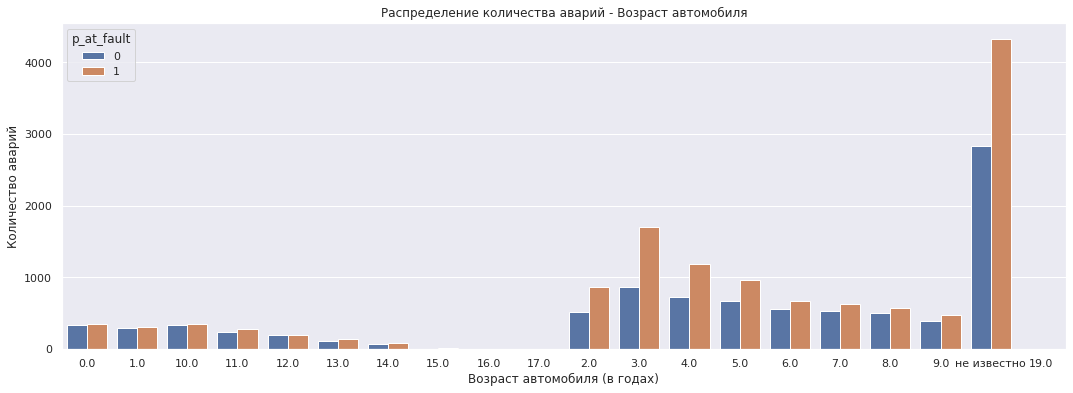

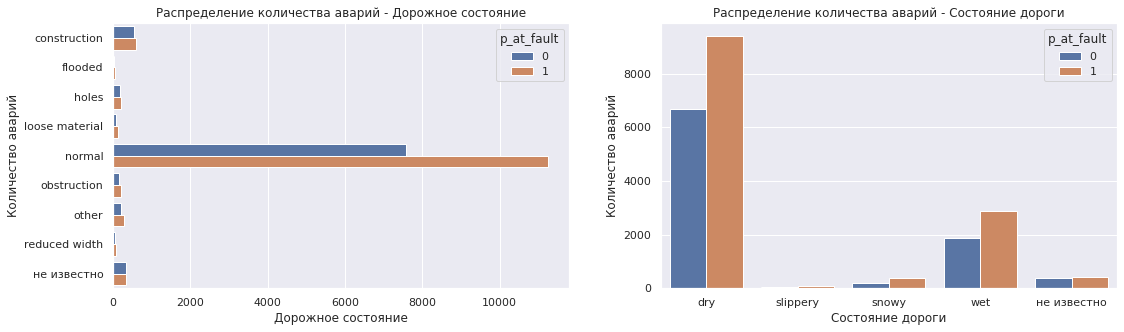

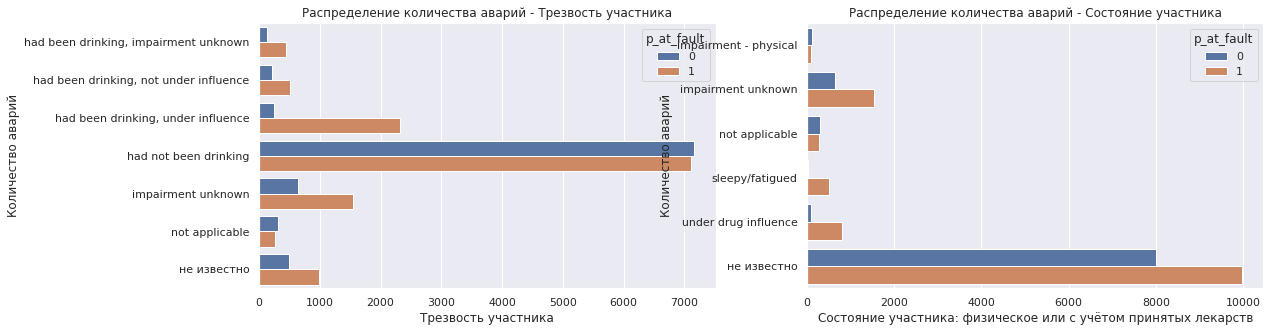

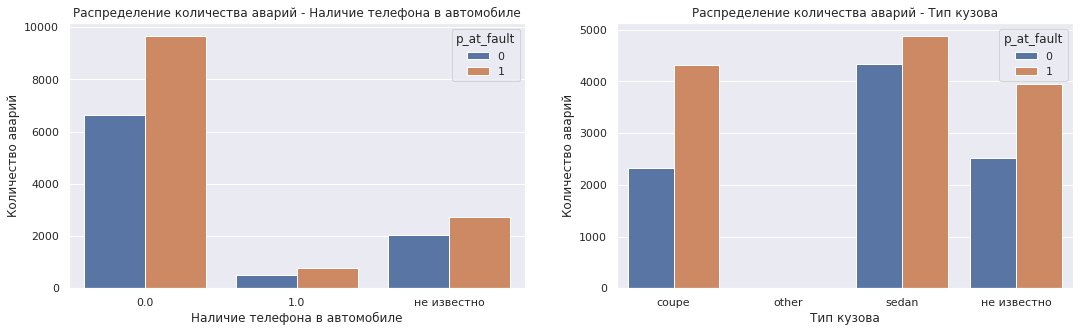

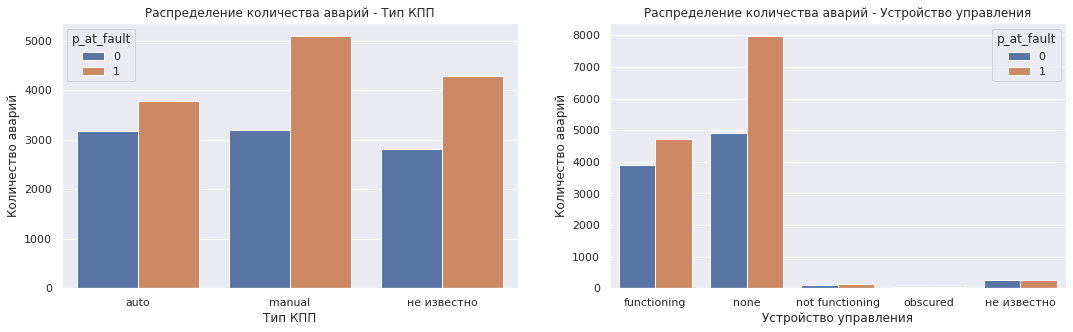

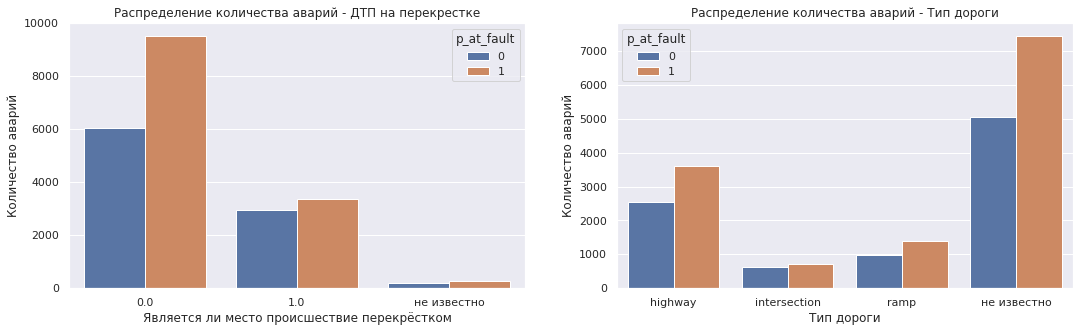

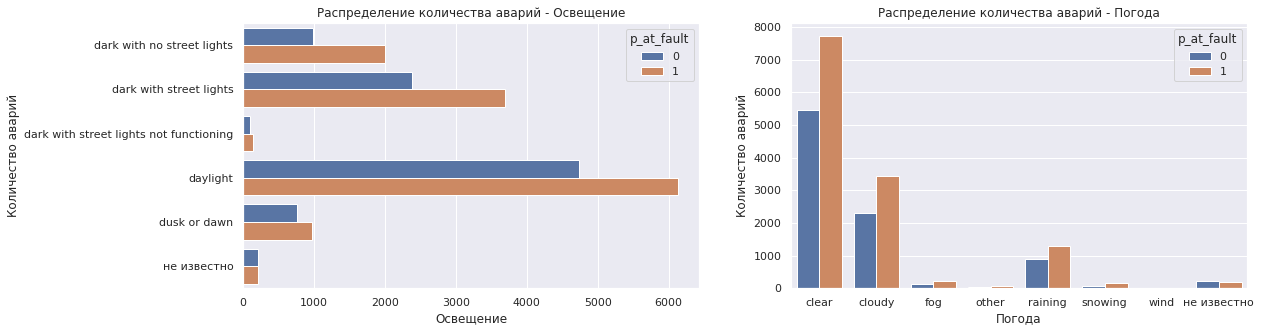

In [42]:
sns.set(rc={'figure.figsize':(18,6)})


pivot_table = pd.pivot_table(data, index=['p_at_fault','v_vehicle_age'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='v_vehicle_age',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Возраст автомобиля')
ax.set(xlabel='Возраст автомобиля (в годах)', ylabel='Количество аварий');
plt.show()


sns.set(rc={'figure.figsize':(18,40)})

pylab.subplot(7, 2, 1)
pivot_table = pd.pivot_table(data, index=['p_at_fault','c_road_condition_1'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='count',
            y='c_road_condition_1',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Дорожное состояние')
ax.set(xlabel='Дорожное состояние', ylabel='Количество аварий');

pylab.subplot(7, 2, 2)
pivot_table = pd.pivot_table(data, index=['p_at_fault','c_road_surface'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='c_road_surface',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Состояние дороги')
ax.set(xlabel='Состояние дороги', ylabel='Количество аварий');
plt.show()

pylab.subplot(7, 2, 3)
pivot_table = pd.pivot_table(data, index=['p_at_fault','p_party_sobriety'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='count',
            y='p_party_sobriety',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Трезвость участника')
ax.set(xlabel='Трезвость участника', ylabel='Количество аварий');

pylab.subplot(7, 2, 4)
pivot_table = pd.pivot_table(data, index=['p_at_fault','p_party_drug_physical'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='count',
            y='p_party_drug_physical',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Состояние участника')
ax.set(xlabel='Состояние участника: физическое или с учётом принятых лекарств', ylabel='Количество аварий');
plt.show()

pylab.subplot(7, 2, 5)
pivot_table = pd.pivot_table(data, index=['p_at_fault','p_cellphone_in_use'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='p_cellphone_in_use',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Наличие телефона в автомобиле')
ax.set(xlabel='Наличие телефона в автомобиле', ylabel='Количество аварий');

pylab.subplot(7, 2, 6)
pivot_table = pd.pivot_table(data, index=['p_at_fault','v_vehicle_type'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='v_vehicle_type',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Тип кузова')
ax.set(xlabel='Тип кузова', ylabel='Количество аварий');
plt.show()

pylab.subplot(7, 2, 7)
pivot_table = pd.pivot_table(data, index=['p_at_fault','v_vehicle_transmission'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='v_vehicle_transmission',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Тип КПП')
ax.set(xlabel='Тип КПП', ylabel='Количество аварий');

pylab.subplot(7, 2, 8)
pivot_table = pd.pivot_table(data, index=['p_at_fault','c_control_device'], values='c_road_condition_1', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_road_condition_1': 'count'})
ax = sns.barplot(x='c_control_device',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Устройство управления')
ax.set(xlabel='Устройство управления', ylabel='Количество аварий');
plt.show()

pylab.subplot(7, 2, 9)
pivot_table = pd.pivot_table(data, index=['p_at_fault','c_intersection'], values='c_road_condition_1', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_road_condition_1': 'count'})
ax = sns.barplot(x='c_intersection',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - ДТП на перекрестке')
ax.set(xlabel='Является ли место происшествие перекрёстком', ylabel='Количество аварий');

pylab.subplot(7, 2, 10)
pivot_table = pd.pivot_table(data, index=['p_at_fault','c_location_type'], values='c_road_condition_1', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_road_condition_1': 'count'})
ax = sns.barplot(x='c_location_type',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Тип дороги')
ax.set(xlabel='Тип дороги', ylabel='Количество аварий');
plt.show()

pylab.subplot(7, 2, 11)
pivot_table = pd.pivot_table(data, index=['p_at_fault','c_lighting'], values='c_road_condition_1', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_road_condition_1': 'count'})
ax = sns.barplot(x='count',
            y='c_lighting',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Освещение')
ax.set(xlabel='Освещение', ylabel='Количество аварий');

pylab.subplot(7, 2, 12)
pivot_table = pd.pivot_table(data, index=['p_at_fault','c_weather_1'], values='c_road_condition_1', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_road_condition_1': 'count'})
ax = sns.barplot(x='c_weather_1',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Погода')
ax.set(xlabel='Погода', ylabel='Количество аварий');

Выводы, которые мы можем сделать согласно графикам:
1. `Возраст автомобиля (в годах)` - В основном, не известен, и некоторое превышение виновников мы можем наблюдать у автомобилей возрастом 3 года. Здесь можно порекомендовать бизнесу внести информацию по возрасту авто для улучшения метрики качества модели.
2. `Дорожное состояние` - Отражает почти полностью нормальное состояние для всех аварий в датасете.
3. `Состояние дороги` - В основном, аварии случались на сухой дороге, но тут мы можем наблюдать увеличение виновных водителей над невиновными на влажной дороге, возможно, это зависит от автопарка бизнеса (к примеру, авто необходимо отправить на ТО для определения состояния тормозной системы и т.д.).
4. `Трезвость участника` - Наибольшая часть аварий случалась с водителями без влияния, однако тут можно заметить, что сильно выделяются виновники в состоянии "Был пьян, под влиянием", а также "Неизвестно ухудшение" (последнее может быть связано с уходом водителя с места аварии и от ответственности.
5. `Состояние участника: физическое или с учётом принятых лекарств` - Аналогичная ситуация, в том числе и по "Неизвестно ухудшение".
6. `Наличие телефона в автомобиле` - Примерно одинаковое соотношение в каждой бакете, какого-либо влияния на виновность нет.
7. `Тип кузова` - Здесь мы видим, что виновники выделяются в части кузова "COUPE", это может быть связано с тем, что водители таких авто чаще имеют желание превысить скорость.
8. `Тип КПП` - Отражает общую картину, где виновных в общем случае несколько меньше, чем невиновных, однако на типе "ручная" мы видим некоторое повышение виновных водителей. Возможно, это связано со сложностью управления, особенно в ЧС.
9. `Устройство управления` - В целом, либо функцианирует, либо информация отсутствует, какого-либо влияния на виновность нет.
10. `Является ли место происшествие перекрёстком` - Аварии на перекрестке случаются заметно реже, однако, график скорее отражает аварии на перекрестке между двумя авто. А вот не на перекрестке также добавляются аварии при участии только одного авто (виновника): въезды в знаки, элементы и т.д.
11. `Тип дороги` - Чаще всего неизвестен, трудно предположить, с чем это связано. Однако по имеющейся информации, чаще всего аварии происходят на шоссе, причем виновников больше, что опять же означает, что водители часто врезаются в элементы дорог: знаки и т.д. (т.е. пострадавшие авто отсутствуют).
12. `Освещение` - Примерно одинаковое соотношение виновных/невиновных. Чаще всего аварии происходят в дневное время. При этом в ночное время по количеству аварий происходит не меньше, и количество аварий с одним участником в это время суток увеличивается.
13. `Погода` - Чаще всего аварии происходят в обычную погоду, не мешающую дорожно-транспортному движунию: ясная и облачная. Однако, мы можем наблюдать также некоторое количество аварий в дождливую погоду, поскольку дождь может стать причиной ухудшения видимости на дороге.

In [43]:
# КОД РЕВЬЮЕРА
data.duplicated().sum()

0

- **Разделение на тренировочную и тестовую выборки**

In [44]:
X = data.drop('p_at_fault', axis=1)
y = data['p_at_fault']

# Разделение выборки на обучающую, валидационную и тестовую в соотношении 3:1:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_train.head()

,c_intersection,c_weather_1,c_location_type,c_road_surface,c_road_condition_1,c_lighting,c_control_device,p_party_sobriety,p_party_drug_physical,p_cellphone_in_use,v_vehicle_type,v_vehicle_transmission,v_vehicle_age
13941,1.0,clear,intersection,dry,construction,dark with street lights,functioning,"had been drinking, under influence",не известно,0.0,coupe,auto,5.0
13474,1.0,cloudy,не известно,wet,normal,dark with street lights,functioning,had not been drinking,не известно,0.0,coupe,не известно,3.0
8585,0.0,cloudy,не известно,wet,normal,daylight,none,not applicable,not applicable,не известно,sedan,manual,не известно
20,1.0,clear,не известно,dry,normal,daylight,functioning,had not been drinking,не известно,не известно,не известно,не известно,не известно
20216,не известно,cloudy,не известно,dry,normal,dusk or dawn,none,impairment unknown,impairment unknown,не известно,не известно,не известно,не известно


- **Нормализация данных**

Числовые данные для обучения модели отсутствуют, поэтому проведем только кодирование категориальных признаков. Поскольку далее мы будем отражать графически важность признаков, используем OrdinalEncoder() для кодирования: он не создаст новых колонок, а закодирует каждое новое значение в существующих признаках своим числом.

In [45]:
# Создание экземпляра OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='ignore')

# Замена категориальных значений в DataFrame на числовые
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

X_train

array([[ 1.,  0.,  1., ...,  0.,  0., 14.],
       [ 1.,  1.,  3., ...,  0.,  2., 12.],
       [ 0.,  1.,  3., ...,  2.,  1., 19.],
       ...,
       [ 1.,  1.,  3., ...,  0.,  1., 15.],
       [ 0.,  0.,  3., ...,  2.,  1.,  0.],
       [ 0.,  0.,  3., ...,  0.,  1., 13.]])

Наши данные подготовлены, теперь мы можем провести обучение и оценку моделей. По условиям задачи необходимо было выбрать 1-2 из базовых моделей (`LogisticRegression`/`RandomForestClassifier`/`DecisionTreeClassifier`) и 1-2 бустинговые модели.

Обучим далее `LogisticRegression`, `RandomForestClassifier` и `CatBoostClassifier` с кросс-валидацией и подбором гиперпараметров с помощью `GridSearchCV` для первых двух моделей, а для последней используем встроенный подбор параметров и кросс-валидацию.

- **LogisticRegression**

In [46]:
# Создание объекта модели LogisticRegression
model = LogisticRegression(random_state=42)

# Задаем пространство параметров для GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Создание объекта GridSearchCV для подбора гиперпараметров
grid_search_LR = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='f1_macro', verbose = 0)

# Обучение модели с подбором гиперпараметров
grid_search_LR.fit(X_train, y_train)

# Получение предсказаний для валидационной выборки
y_pred = grid_search_LR.predict(X_val)

# Вывод наилучших гиперпараметров
print("Лучшие гиперпараметры:", grid_search_LR.best_params_)

# Оценка качества модели
report = classification_report(y_val, y_pred)
print(report)

Лучшие гиперпараметры: {'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.50      0.24      0.33      1783
           1       0.63      0.84      0.72      2689

    accuracy                           0.60      4472
   macro avg       0.56      0.54      0.52      4472
weighted avg       0.58      0.60      0.56      4472



Логистическая регрессия показывает достаточно высокие показатели F1 и Полноту для виновного водителя, однако, также важно определять невиновных в ДТП водителей. Поэтому используем `predict_proba` для смещения порога и посмотрим на результат.

In [47]:
# Предсказание вероятности принадлежности к классам на валидационной выборке
y_proba = grid_search_LR.predict_proba(X_val)

# Задание порога
threshold = 0.58

# Применение порога для определения класса
y_pred = (y_proba[:, 1] >= threshold).astype(int)

# Вывод отчета о классификации
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.58      0.53      1783
           1       0.68      0.58      0.63      2689

    accuracy                           0.58      4472
   macro avg       0.58      0.58      0.58      4472
weighted avg       0.60      0.58      0.59      4472



По итогам экспериментов был подобран максимально подходящий порог, дающий более `0.5`, а показатели определения вины имеют показатель побольше: `F1 - 0.64`, `Полнота - 0.61`.

- **RandomForestClassifier**

In [48]:
# Создание объекта модели RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Задаем пространство параметров для GridSearchCV
param_grid = {
    'n_estimators': [1, 5, 10, 20],
    'max_depth': [1, 5, 10, 20],
    'max_features': ['auto', 'sqrt']
}

# Создание объекта GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='f1_macro')

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Получение предсказаний для валидационной выборки
y_pred = grid_search.predict(X_val)

# Вывод наилучших гиперпараметров
print("Лучшие гиперпараметры:", grid_search.best_params_)
print()

# Оценка качества модели
report = classification_report(y_val, y_pred)
print(report)

Лучшие гиперпараметры: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}

              precision    recall  f1-score   support

           0       0.52      0.52      0.52      1783
           1       0.68      0.68      0.68      2689

    accuracy                           0.62      4472
   macro avg       0.60      0.60      0.60      4472
weighted avg       0.62      0.62      0.62      4472



Также применим `predict_proba` для смещения порога и посмотрим на результат.

In [49]:
# Предсказание вероятности принадлежности к классам на тестовых данных
y_proba = grid_search.predict_proba(X_val)

# Задание порога
threshold = 0.5

# Применение порога для определения класса
y_pred = (y_proba[:, 1] >= threshold).astype(int)

# Вывод отчета о классификации
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      1783
           1       0.68      0.68      0.68      2689

    accuracy                           0.62      4472
   macro avg       0.60      0.60      0.60      4472
weighted avg       0.62      0.62      0.62      4472



После применения различных порогов результат не поменялся, так как порог по умолчанию дает наиболее высокие показатели. Показатели определения вины имеют: `F1 - 0.68`, `Полнота - 0.68`.

- **CatBoostClassifier**

In [50]:
train_pool = Pool(X_train, label=y_train)
val_pool = Pool(X_val, label=y_val)
test_pool = Pool(X_test, label=y_test)

In [51]:
# Создание модели CatBoostClassifier
params = {
              'iterations': 1000,
              'early_stopping_rounds': 50,
              'verbose': False,
              'learning_rate': 0.01
             }

model = CatBoostClassifier(**params, random_state=42)

# Определение сетки гиперпараметров для поиска
param_grid = {
              'depth': [3, 5, 7, 9, 15],
              'l2_leaf_reg': [1, 5, 9],
             }

grid_search_result = model.grid_search(param_grid, 
                                       train_pool,
                                       cv=3,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6090356941
bestIteration = 999

0:	loss: 0.6090357	best: 0.6090357 (0)	total: 3.61s	remaining: 50.5s

bestTest = 0.6090454061
bestIteration = 999

1:	loss: 0.6090454	best: 0.6090357 (0)	total: 6.92s	remaining: 45s

bestTest = 0.6091209888
bestIteration = 999

2:	loss: 0.6091210	best: 0.6090357 (0)	total: 10.3s	remaining: 41.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6103892029
bestIteration = 768

3:	loss: 0.6103892	best: 0.6090357 (0)	total: 13.6s	remaining: 37.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6098196297
bestIteration = 836

4:	loss: 0.6098196	best: 0.6090357 (0)	total: 17.4s	remaining: 34.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6096390547
bestIteration = 839

5:	loss: 0.6096391	best: 0.6090357 (0)	total: 21s	remaining: 31.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6139727158
bestIteration = 360

6:	loss: 0.6139727	best: 0.6090357 (0)	total: 23.1s	

In [52]:
# Лучшие гиперпараметры
best_params = grid_search_result['params']
print('Лучшие параметры:', best_params)
print()

# Создание модели с лучшими гиперпараметрами
best_model = CatBoostClassifier(**best_params, verbose=50, random_state=42)  

# Обучение модели на полном тренировочном наборе данных
best_model.fit(train_pool)

# Предсказание на валидационной выборке
y_pred = best_model.predict(val_pool)

report = classification_report(y_val, y_pred)
print()
print(report)

Лучшие параметры: {'depth': 3, 'l2_leaf_reg': 1}

0:	learn: 0.6883321	total: 3.74ms	remaining: 3.73s
50:	learn: 0.6232832	total: 152ms	remaining: 2.82s
100:	learn: 0.6155630	total: 285ms	remaining: 2.53s
150:	learn: 0.6121705	total: 418ms	remaining: 2.35s
200:	learn: 0.6096557	total: 551ms	remaining: 2.19s
250:	learn: 0.6074700	total: 688ms	remaining: 2.05s
300:	learn: 0.6057429	total: 823ms	remaining: 1.91s
350:	learn: 0.6040901	total: 964ms	remaining: 1.78s
400:	learn: 0.6024860	total: 1.1s	remaining: 1.64s
450:	learn: 0.6012780	total: 1.24s	remaining: 1.5s
500:	learn: 0.6000909	total: 1.38s	remaining: 1.38s
550:	learn: 0.5990819	total: 1.52s	remaining: 1.24s
600:	learn: 0.5980348	total: 1.66s	remaining: 1.1s
650:	learn: 0.5972369	total: 1.8s	remaining: 966ms
700:	learn: 0.5964437	total: 1.94s	remaining: 827ms
750:	learn: 0.5956707	total: 2.08s	remaining: 690ms
800:	learn: 0.5949510	total: 2.22s	remaining: 552ms
850:	learn: 0.5942791	total: 2.37s	remaining: 414ms
900:	learn: 0.593648

Применим `predict_proba` для смещения порога и посмотрим на результат.

In [53]:
# Предсказание вероятности принадлежности к классам на тестовых данных
y_proba = best_model.predict_proba(X_val)

# Задание порога
threshold = 0.5

# Применение порога для определения класса
y_pred = (y_proba[:, 1] >= threshold).astype(int)

# Вывод отчета о классификации
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1783
           1       0.71      0.68      0.70      2689

    accuracy                           0.64      4472
   macro avg       0.63      0.63      0.63      4472
weighted avg       0.64      0.64      0.64      4472



Эксперименты с порогом также не дали результатов лучше, чем по умолчанию. Метрики качества подросли по сравнению с предыдущими моделями, правда несущественно. Показатели определения вины имеют: `F1 - 0.68`, `Полнота - 0.69`, однако тут у нас подросли также данные показатели по невиновному.

- **Тестирование**

Таким образом, лучше всего обучилась модель `CatBoostClassifier`, выберем ее для финального тестирования.

In [54]:
# Предсказание вероятности принадлежности к классам на тестовых данных
y_proba = best_model.predict_proba(X_test)

# Применение порога для определения класса
y_pred = (y_proba[:, 1] >= threshold).astype(int)

# Вывод отчета о классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.56      0.55      1844
           1       0.68      0.68      0.68      2628

    accuracy                           0.63      4472
   macro avg       0.62      0.62      0.62      4472
weighted avg       0.63      0.63      0.63      4472



Мы видим, что наша модель показывает близкие значения метрики качества к тренировочным, наша модель не переобучилась, но показывает результаты даже чуть ниже: `F1 - 0.67`, `Полнота - 0.67`. Это достаточно высокий результат, учитывая, что для данного проекта нам важнее правильно предсказывать именно виновника аварии.

## 5. Анализ важности факторов ДТП

Проведем графический анализ «Матрица ошибок».

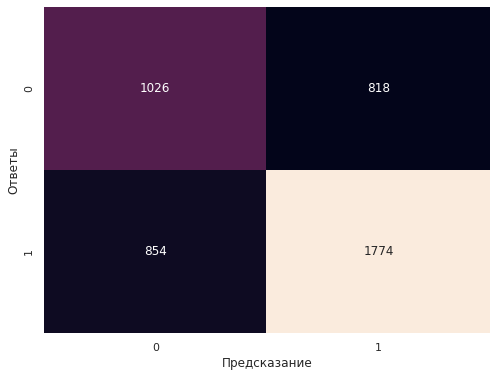

In [55]:
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок в виде тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Предсказание')
plt.ylabel('Ответы')
plt.show()

Согласно графику мы видим, что общее количество ответов 4 472 разделились по корзинам:
- `0-0` Корректное предсказание 0
- `1-1` Корректное предсказание 1
- `1-0` Ошибочное предсказание 0
- `0-1` Ошибочное предсказание 1

Полнота по всему тесту составила `(857+1822)/1822=0.68`, что соответствует `classification_report` выше. Корректное определение виновности водителя в 1.8 раз выше, чем у невиновных. При этом неправильные предсказания (`1-0` и `0-1`) заметно ниже.

Выведем полноту и точность на график по результатам обучения.

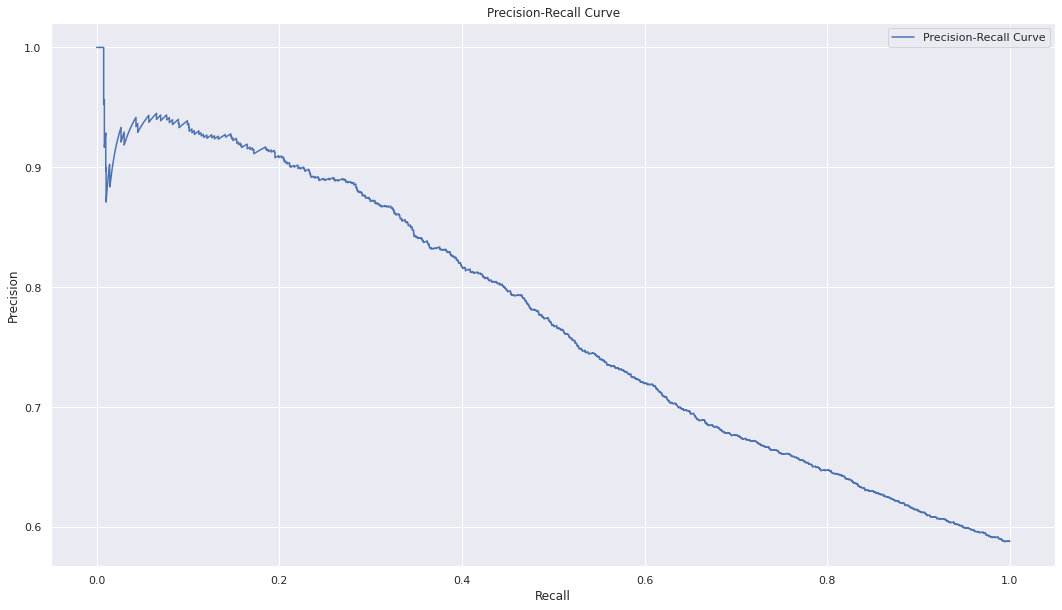

In [56]:
# Получение предсказанных вероятностей класса 1
y_scores = best_model.predict_proba(X_test)[:, 1]

# Вычисление Precision, Recall и пороговых значений
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Вывод графика Precision-Recall Curve
plt.figure(figsize=(18, 10))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

В целом, мы можем наблюдать планомерное снижение точности в угоду полноте, есть некоторые всплески и падения непосредственно перед абсолютной Точностью и абсолютной Полнотой, но они несущественны.

Проведем анализ важности признаков у данной модели. Для этого используем `feature_importances_` и визуализируем.

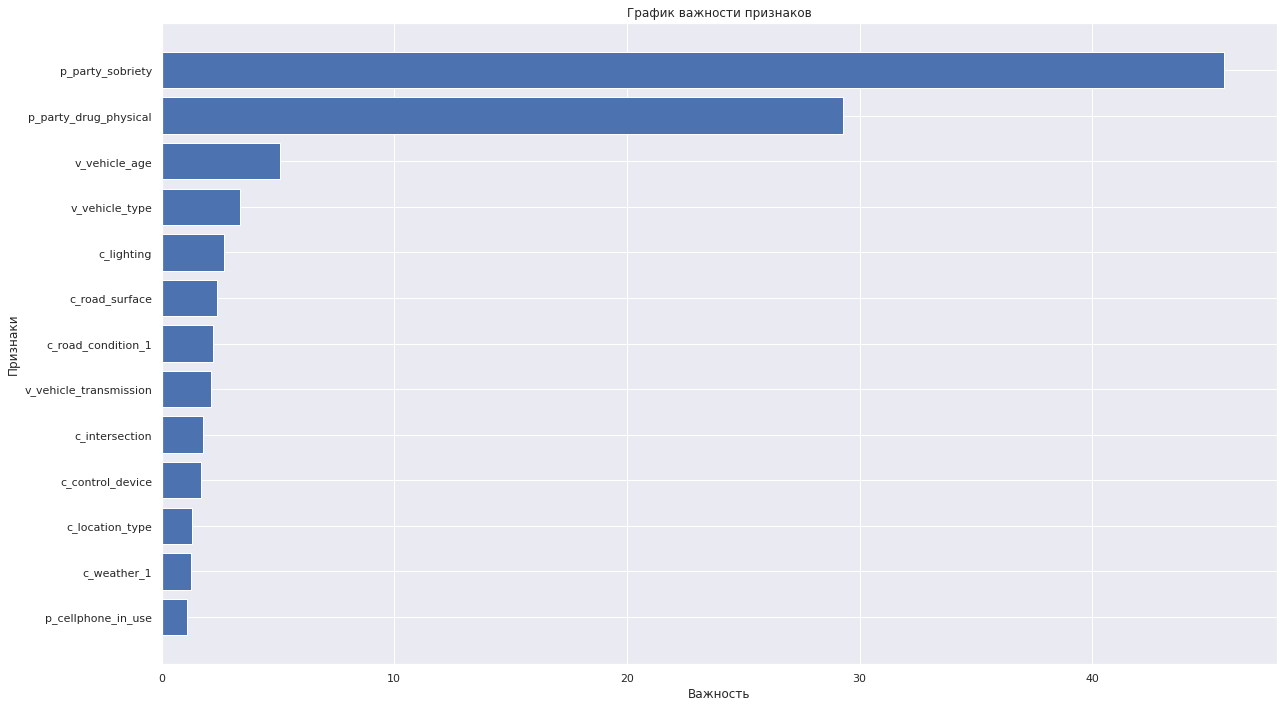

In [57]:
# Получение значения важности признаков
importance = best_model.feature_importances_

# Сортировка значений важности по убыванию
sorted_indices = sorted(range(len(importance)), key=lambda k: importance[k])
sorted_importance = [importance[i] for i in sorted_indices]
sorted_feature_names = [data.drop('p_at_fault', axis=1).columns[i] for i in sorted_indices]

# Вывод графика важности признаков
plt.figure(figsize=(18, 10))
plt.barh(range(len(importance)), sorted_importance)
plt.yticks(range(len(importance)), sorted_feature_names)
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('График важности признаков')
plt.tight_layout()
plt.show()

Согласно графику можно сказать, что почти наибольшее влияние на виновность водителя имеют признаки `p_party_sobriety` (Трезвость участника) и `p_party_drug_physical` (Состояние участника). Рассмотрим их еще раз подробнее на графиках.

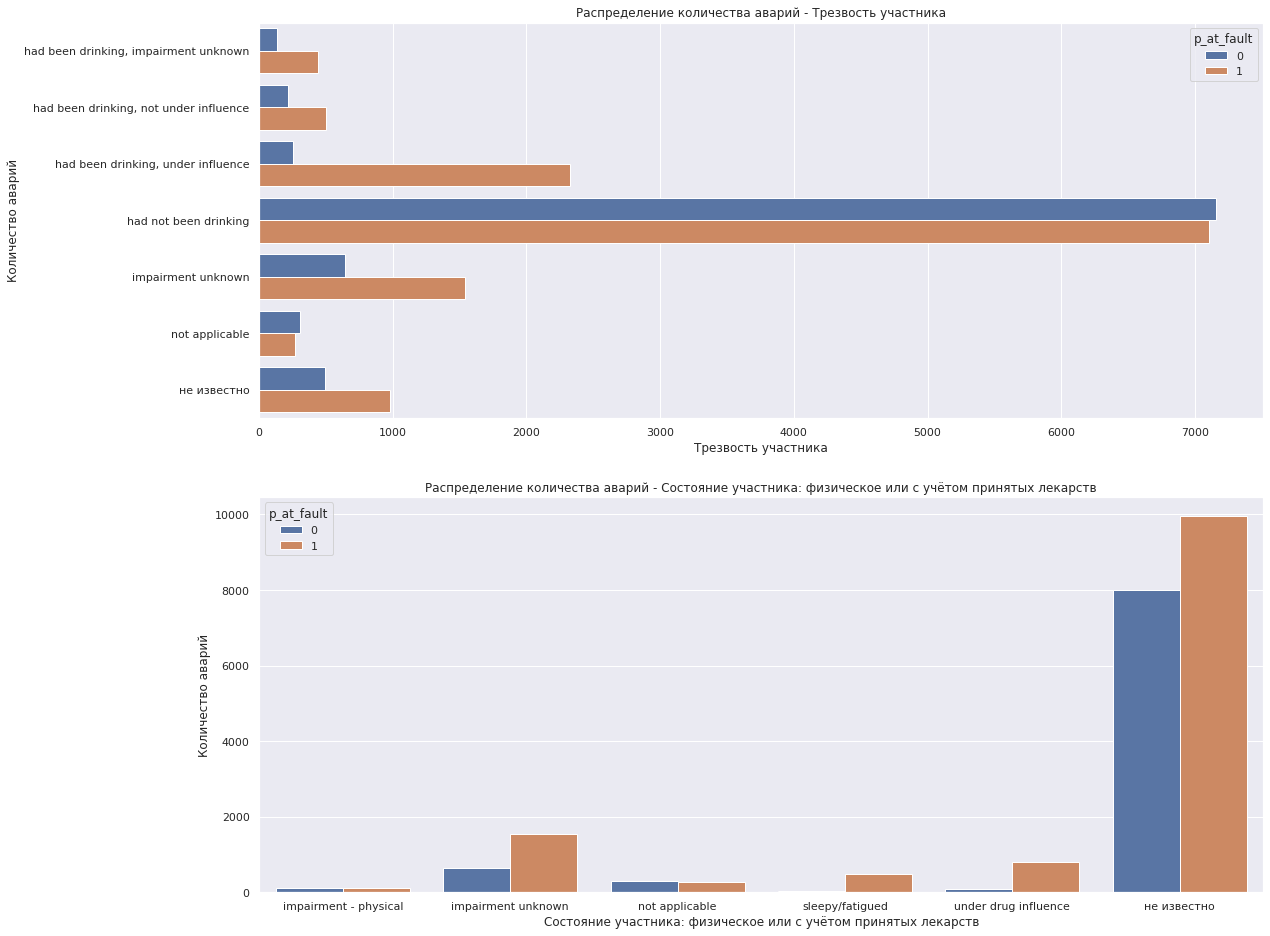

In [58]:
sns.set(rc={'figure.figsize':(18,16)})

pylab.subplot(2, 1, 1)
pivot_table = pd.pivot_table(data, index=['p_at_fault','p_party_sobriety'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='count',
            y='p_party_sobriety',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Трезвость участника')
ax.set(xlabel='Трезвость участника', ylabel='Количество аварий');

pylab.subplot(2, 1, 2)
pivot_table = pd.pivot_table(data, index=['p_at_fault','p_party_drug_physical'], values='c_control_device', aggfunc='count')
df_stat = pd.DataFrame(pivot_table.to_records()).reset_index(drop=True).rename(columns={'c_control_device': 'count'})
ax = sns.barplot(x='p_party_drug_physical',
            y='count',
            hue='p_at_fault',
            data=df_stat)
ax.set_title('Распределение количества аварий - Состояние участника: физическое или с учётом принятых лекарств')
ax.set(xlabel='Состояние участника: физическое или с учётом принятых лекарств', ylabel='Количество аварий');

Напомним ранее сделанные выводы:
1. `Трезвость участника` - Наибольшая часть аварий случалась с водителями без влияния, однако тут можно заметить, что сильно выделяются виновники в состоянии "Был пьян, под влиянием", а также "Неизвестно ухудшение" (последнее может быть связано с уходом водителя с места аварии и от ответственности.
2. `Состояние участника: физическое или с учётом принятых лекарств` - Аналогичная ситуация, в том числе и по "Неизвестно ухудшение".

По итогу можно предположить общий портрет виновника ДТП: это водитель, надодящийся в состоянии алкогольного опьянения, который, вероятно, в части случаев сбегал с места ДТП, чтобы нельзя было зафиксировать состояние алкогольного опьянения.

## Выводы

**Шаг 7. Общий вывод по модели**

- Описание лучшей модели.

В рамках данного проекта была обучена модель для предсказания виновности водителя в ДТП. Наилучшим образом (но с несущественным отрывом) показала себя бустинговая модель `CatBoostClassifier` с метриками качества: `F1 - 0.67`, `Полнота - 0.67` для определения виновника ДТП. В ходе обучения был использован встроенный инструмент кросс-валидации и подбора гиперпараметров, также были проведены эксперименты с порогами и определен лучший.

- Насколько возможно создание адекватной системы оценки риска при выдаче авто?

Результаты обученной модели выше среднего, но все еще далеко от совершенства. При выполнении рекомендаций бизнесу (см. ниже) можно значительно поднять метрику качества.

- Какие факторы ещё необходимо собирать, чтобы улучшить модель?

Подведем итог для бизнеса:

- Установика детектора алкоголя в салон авто с автоматическим блоком двигателя до прохождения тестирования водителем позволит снизить риски попадания в аварию (но при решении бизнеса поможет как минимум улучшить обучение модели при добавлении информации в БД). Для подтверждения водителя и действия можно установить в салон камеру.
- Прохождение опроса о состоянии водителя (прием лекарств, усталось и т.д.) с автоматическим блоком двигателя до прохождения тестирования водителем и наполнение этой информацией БД повысит качество обучения, стоит ли запрещать водителю вести авто и при каком состоянии - решать бизнесу.
- Заполнение массово отсутствующей информации по автомобилю. Это является не такой сложной задачей для автоматизации каршеринговой компании, однако эта информация может помочь существенно повысить качество модели и предсказания.
- Добавление информации о возрасте водителя по паспорту также может значительно повысить качество предсказаний, особенно, если предположительный портрет виновника ДТП подтвердится (в юном возрасте чаще превышают скорость, в т.ч. в состоянии алкогольного опьянения).